# Checkpoint 2: Pytorch Model Experimentation

In [1]:
# import packages

import cv2
import os
import random
import torch
import sklearn
import seaborn
import pickle
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

from data_utils import DisasterImageDataset

## Util Functions

### Image Preprocessing

In [2]:
def norm_scale_img(img, img_size=(180,180)):
    new_img = [i/255 for i in img]
    new_img = [cv2.resize(i, (180, 180)) for i in new_img]
    new_img = np.array([np.transpose(i, (2, 0, 1)) for i in new_img])
    return new_img

def rotate_img(img):
    rot_img = np.array([cv2.rotate(i, random.randint(0, 360)) for i in img])
    return rot_img

def remove_zeros(labels):
    keep_idx = [i for i in range(len(labels)) if labels[i] != 0]
    print(f"removed {len(labels) - len(keep_idx)} images with damage type 0")
    return keep_idx

### Model Training

In [56]:
def eval_model(model, val_loader, loss_fn, task_type="A"):

    model.eval()
    val_acc, val_loss = 0, 0

    for i, (X, Y_label, Y_type) in enumerate(val_loader):

        Y_pred = model(X)
        
        if task_type == "A":
            loss = loss_fn(Y_pred[:, 0], Y_type[:, 0])
        elif task_type =="B":
            loss = loss_fn(Y_pred, Y_label)

        val_loss += loss.detach().cpu().item()

        if task_type == "A":
            acc = torch.sum(torch.argmax(Y_pred, axis=-1) == torch.argmax(Y_type, axis=-1)) / len(Y_pred)
        elif task_type == "B":
            acc = torch.sum(torch.argmax(Y_pred, axis=-1) == Y_label) / len(Y_pred) 

        val_acc += acc.detach().cpu().item()

    return val_loss, val_acc


def train_model(model, train_loader, val_loader, n_epochs, learning_rate, optimizer_type, loss_fn, task_type="A", device="cpu", draw_curve=False, early_stop=False, l2=False):
    
    model = model.to(device)

    train_loss, train_acc, val_loss, val_acc, = [], [], [], []
    weights = model.state_dict()
    lowest_val = np.inf

    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), learning_rate)
    else:
        raise NotImplementedError("only SGD and Adam optimizers implemented")

    for epoch in tqdm(range(n_epochs), leave=False):
        
        model.train()
        e_loss, e_acc = 0, 0
        
        for i, (X, Y_label, Y_type) in enumerate(train_loader):
            Y_pred = model(X)
            
            if task_type == "A":
                loss = loss_fn(Y_pred[:, 0], Y_type[:, 0])
            elif task_type =="B":
                loss = loss_fn(Y_pred, Y_label)
            else:
                raise ValueError("task_type must be A or B")

            if l2:
                l2_lambda = 1e-5
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + l2_lambda + l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            e_loss += loss.detach().cpu().item()

            if task_type == "A":
                acc = torch.sum(torch.argmax(Y_pred, axis=-1) == torch.argmax(Y_type, axis=-1)) / len(Y_pred)
            
            elif task_type == "B":
                acc = torch.sum(torch.argmax(Y_pred, axis=-1) == Y_label) / len(Y_pred) 

            e_acc += acc.detach().cpu().item()

        v_loss, v_acc =  eval_model(model, val_loader, loss_fn, task_type)

        print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (epoch+1, n_epochs, e_loss, e_acc))
        print("             Val Loss: %.3f - Val Acc: %.3f" % (v_loss, v_acc))

        train_loss.append(e_loss)
        train_acc.append(e_acc)
        val_loss.append(v_loss)
        val_acc.append(v_acc)

        if early_stop:
            if v_loss < lowest_val:
                lowest_val = v_loss
                weights = model.state_dict()

    if draw_curve:

        plt.figure()
        plt.plot(np.arange(n_epochs) + 1, train_loss, label="Training Loss")
        plt.plot(np.arange(n_epochs) + 1, val_loss, label="Validation Loss")

        plt.xlabel("Epochs")
        plt.ylabel("Loss")

        plt.title(f"Task {task_type} Model Performance\nEpochs {n_epochs} | LR {learning_rate} | OPT {optimizer_type}")
        plt.legend()

    if early_stop:
        model.load_state_dict(weights)

    return {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}  

## Model Task A: Classifying Fire vs. Flood Disaster Types

### Dataset Generation

removed 7204 images with damage type 0
removed 6734 images with damage type 0
1176
270
(3, 180, 180)
tensor(3.) tensor([1., 0.])


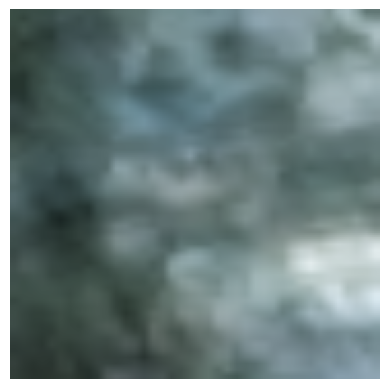

(tensor([[[0.2275, 0.2275, 0.2270,  ..., 0.3843, 0.3843, 0.3843],
         [0.2275, 0.2275, 0.2270,  ..., 0.3843, 0.3843, 0.3843],
         [0.2275, 0.2275, 0.2267,  ..., 0.4123, 0.4119, 0.4119],
         ...,
         [0.1973, 0.1973, 0.1961,  ..., 0.5549, 0.5545, 0.5545],
         [0.1961, 0.1961, 0.1950,  ..., 0.5606, 0.5608, 0.5608],
         [0.1961, 0.1961, 0.1950,  ..., 0.5606, 0.5608, 0.5608]],

        [[0.3020, 0.3020, 0.3015,  ..., 0.4708, 0.4706, 0.4706],
         [0.3020, 0.3020, 0.3015,  ..., 0.4708, 0.4706, 0.4706],
         [0.3020, 0.3020, 0.3010,  ..., 0.4988, 0.4981, 0.4981],
         ...,
         [0.2431, 0.2431, 0.2418,  ..., 0.6423, 0.6420, 0.6420],
         [0.2431, 0.2431, 0.2418,  ..., 0.6468, 0.6471, 0.6471],
         [0.2431, 0.2431, 0.2418,  ..., 0.6468, 0.6471, 0.6471]],

        [[0.2706, 0.2706, 0.2704,  ..., 0.4630, 0.4627, 0.4627],
         [0.2706, 0.2706, 0.2704,  ..., 0.4630, 0.4627, 0.4627],
         [0.2693, 0.2693, 0.2687,  ..., 0.4922, 0.4916, 0

In [4]:
# load dataset

fire_img = "../Data/sp24_grad_project_data/satellite-image-data/socal-fire/train_images.npz"
fire_labels = "../Data/sp24_grad_project_data/satellite-image-data/socal-fire/train_labels.npy"

flood_img = "../Data/sp24_grad_project_data/satellite-image-data/midwest-flooding/train_images.npz"
flood_labels = "../Data/sp24_grad_project_data/satellite-image-data/midwest-flooding/train_labels.npy"

fire_data = DisasterImageDataset(fire_img, fire_labels, "fire", remove_zeros, norm_scale_img)
flood_data = DisasterImageDataset(flood_img, flood_labels, "flood", remove_zeros, norm_scale_img)

print(len(fire_data))
print(len(flood_data))

print(fire_data.images[0].shape)
print(fire_data[0][1], fire_data[0][2])
fire_data.display(0)
print(fire_data[0])

In [5]:
# split into train and validation sets (80 20)

fire_train, fire_val = random_split(fire_data, [216, 960])
flood_train, flood_val = random_split(flood_data, [216, 54])

train_data = ConcatDataset([fire_train, flood_train])
val_data = ConcatDataset([fire_val, flood_val])

In [6]:
batch_size = 5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

### Model Architecture

In [59]:
class TaskACNN(torch.nn.Module):

    def __init__(self):
        super(TaskACNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # nn.Conv2d(3, 5, kernel_size=5, padding=1),
            # nn.Conv2d(5, 7, kernel_size=5, padding=1),
            # nn.Conv2d(7, 10, kernel_size=5, padding=1),
            nn.Conv2d(3, 6, kernel_size=5, padding=1),
            nn.Conv2d(6, 12, kernel_size=5, padding=1),
        )
    
        self.pooling = nn.MaxPool2d(7, 7)

        self.lin1 = nn.Linear(108, 10)
        self.lin2 = nn.Linear(10, 2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def forward(self, x):

        for i in range(len(self.conv_layers)):
            x = self.pooling(self.relu(self.conv_layers[i](x)))
        x = self.flatten(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.sigmoid(x) 
        return x

### Training

In [61]:
# test model forward

modelA = TaskACNN()
print(flood_data[0][0].shape)
print(flood_data[0][2])
print(modelA(torch.unsqueeze(flood_data[0][0], 0)))

torch.Size([3, 180, 180])
tensor([0., 1.])
tensor([[0.4905, 0.4706]], grad_fn=<SigmoidBackward0>)


 10%|█         | 1/10 [00:06<00:55,  6.14s/it]

Epoch 1/10 - Loss: 60.498 - Acc: 43.300
             Val Loss: 141.495 - Val Acc: 192.000


 20%|██        | 2/10 [00:11<00:45,  5.68s/it]

Epoch 2/10 - Loss: 60.387 - Acc: 43.500
             Val Loss: 141.889 - Val Acc: 192.000


 30%|███       | 3/10 [00:16<00:38,  5.54s/it]

Epoch 3/10 - Loss: 60.374 - Acc: 43.500
             Val Loss: 140.110 - Val Acc: 192.000


 40%|████      | 4/10 [00:22<00:33,  5.66s/it]

Epoch 4/10 - Loss: 60.403 - Acc: 43.500
             Val Loss: 137.520 - Val Acc: 192.000


 50%|█████     | 5/10 [00:28<00:28,  5.67s/it]

Epoch 5/10 - Loss: 60.371 - Acc: 43.500
             Val Loss: 141.804 - Val Acc: 192.000


 60%|██████    | 6/10 [00:33<00:22,  5.59s/it]

Epoch 6/10 - Loss: 60.375 - Acc: 43.500
             Val Loss: 139.106 - Val Acc: 192.000


 70%|███████   | 7/10 [00:39<00:17,  5.70s/it]

Epoch 7/10 - Loss: 60.333 - Acc: 43.500
             Val Loss: 140.166 - Val Acc: 192.000


 80%|████████  | 8/10 [00:51<00:15,  7.69s/it]

Epoch 8/10 - Loss: 60.447 - Acc: 43.200
             Val Loss: 139.567 - Val Acc: 192.000


 90%|█████████ | 9/10 [01:02<00:08,  8.65s/it]

Epoch 9/10 - Loss: 60.382 - Acc: 43.800
             Val Loss: 141.900 - Val Acc: 192.000


Epoch 10/10 - Loss: 60.415 - Acc: 43.500
             Val Loss: 137.896 - Val Acc: 192.000


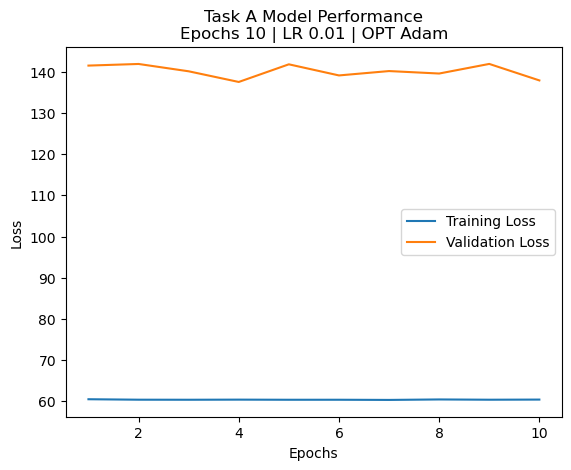

In [62]:
n_epochs = 10
learning_rate = 1e-2
optimizer_type = "Adam"
loss_fn = nn.BCELoss()
# loss_fn = nn.CrossEntropyLoss()


trained_model = train_model(modelA, train_loader, val_loader, n_epochs, learning_rate, optimizer_type, loss_fn, task_type="A", device="cpu", draw_curve=True, early_stop=True, l2=False)

### Evaluation

## Model Task B: Classifying Hurricane Damage Levels 